## Problem Statement
### Perform sentimental analysis on the Elon-musk tweets

In [68]:
#Import Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string
import warnings
import spacy
from tqdm.notebook import tqdm_notebook

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem.porter import PorterStemmer
from plotly import graph_objs as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



# for showing all the plots inline
%matplotlib inline

In [2]:
# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\c

In [37]:
# load the dataset
tweets=pd.read_csv('Elon_musk.csv',encoding='Latin-1')
tweets.drop(['Unnamed: 0'],inplace=True,axis=1)
tweets.rename({'Text':'Tweets'},axis=1,inplace=True)
tweets

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


## Data Exploration

#### Number of Words

In [4]:
tweets['word_count'] = tweets['Tweets'].apply(lambda x: len(str(x).split(" ")))
tweets[['Tweets','word_count']].head()

,Tweets,word_count
0,@kunalb11 Im an alien,4
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13
2,@joerogan @Spotify Great interview!,4
3,@gtera27 Doge is underestimated,4
4,@teslacn Congratulations Tesla China for amazi...,17


#### Number of characters

In [5]:
tweets['char_count'] = tweets['Tweets'].str.len() ## this also includes spaces
tweets[['Tweets','char_count']].head()

,Tweets,char_count
0,@kunalb11 Im an alien,22
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,82
2,@joerogan @Spotify Great interview!,35
3,@gtera27 Doge is underestimated,31
4,@teslacn Congratulations Tesla China for amazi...,104


#### Average Word Length

In [6]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

tweets['avg_word'] = tweets['Tweets'].apply(lambda x: avg_word(x))
tweets[['Tweets','avg_word']].head()

,Tweets,avg_word
0,@kunalb11 Im an alien,4.750000
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,5.384615
2,@joerogan @Spotify Great interview!,8.000000
3,@gtera27 Doge is underestimated,7.000000
4,@teslacn Congratulations Tesla China for amazi...,5.176471


#### Number of Stop Words

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

tweets['stopwords'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x in stop]))
tweets[['Tweets','stopwords']].head()

,Tweets,stopwords
0,@kunalb11 Im an alien,1
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,4
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,1
4,@teslacn Congratulations Tesla China for amazi...,5


#### Number of special characters


In [8]:
tweets['hashtags'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets[['Tweets','hashtags']].head()

,Tweets,hashtags
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


#### Number of numerics


In [9]:
tweets['numerics'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweets[['Tweets','numerics']].head()

,Tweets,numerics
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


#### Number of Upper case words

In [10]:
tweets['upper'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
tweets[['Tweets','upper']].head()

,Tweets,upper
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,1
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


In [12]:
tweets.drop(['numerics','stopwords','avg_word','char_count','word_count','hashtags','upper'],axis=1,inplace=True)

#### Number of Rare Words

In [13]:
freq = pd.Series(' '.join(tweets['Tweets']).split()).value_counts()[-10:]
freq

N3                         1
lab                        1
(N1                        1
detection                  1
Lab                        1
https://t.co/K77wXQ11yt    1
dicey                      1
accurate,                  1
thinks                     1
28                         1
dtype: int64

#### Percentage of Links attached in the tweets

In [14]:
tweets.Tweets.str.contains('https://').value_counts() / len(tweets)

False    0.678339
True     0.321661
Name: Tweets, dtype: float64

#### Percentage of User Tags in the tweets


In [15]:
tweets.Tweets.str.contains('@').value_counts() / len(tweets)

True     0.83942
False    0.16058
Name: Tweets, dtype: float64

### Spelling Correction

In [17]:
!pip install textblob

     -------------------------------------- 636.8/636.8 kB 1.3 MB/s eta 0:00:00


In [18]:
from textblob import TextBlob
tweets['Tweets'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                               @kunalb11 Im an alien
1    @ID_AA_Carmack May tracing on Cyberpunk with H...
2                   @joerogan @Notify Great interview!
3                       @gtera27 One is underestimated
4    @teslacn Congratulations Cela China for amazin...
Name: Tweets, dtype: object

### N-grams
+ N-grams are the combination of multiple words used together. Ngrams with N=1 are called unigrams. Similarly, bigrams (N=2), trigrams (N=3) and so on can also be used

In [19]:
TextBlob(tweets['Tweets'][3]).ngrams(1)

[WordList(['gtera27']),
 WordList(['Doge']),
 WordList(['is']),
 WordList(['underestimated'])]

In [20]:
TextBlob(tweets['Tweets'][2]).ngrams(2)

[WordList(['joerogan', 'Spotify']),
 WordList(['Spotify', 'Great']),
 WordList(['Great', 'interview'])]

In [21]:
TextBlob(tweets['Tweets'][4]).ngrams(3)

[WordList(['teslacn', 'Congratulations', 'Tesla']),
 WordList(['Congratulations', 'Tesla', 'China']),
 WordList(['Tesla', 'China', 'for']),
 WordList(['China', 'for', 'amazing']),
 WordList(['for', 'amazing', 'execution']),
 WordList(['amazing', 'execution', 'last']),
 WordList(['execution', 'last', 'year']),
 WordList(['last', 'year', 'Now']),
 WordList(['year', 'Now', 'on']),
 WordList(['Now', 'on', 'to']),
 WordList(['on', 'to', 'the']),
 WordList(['to', 'the', 'next']),
 WordList(['the', 'next', 'for']),
 WordList(['next', 'for', 'even']),
 WordList(['for', 'even', 'more'])]

## Data Visualization

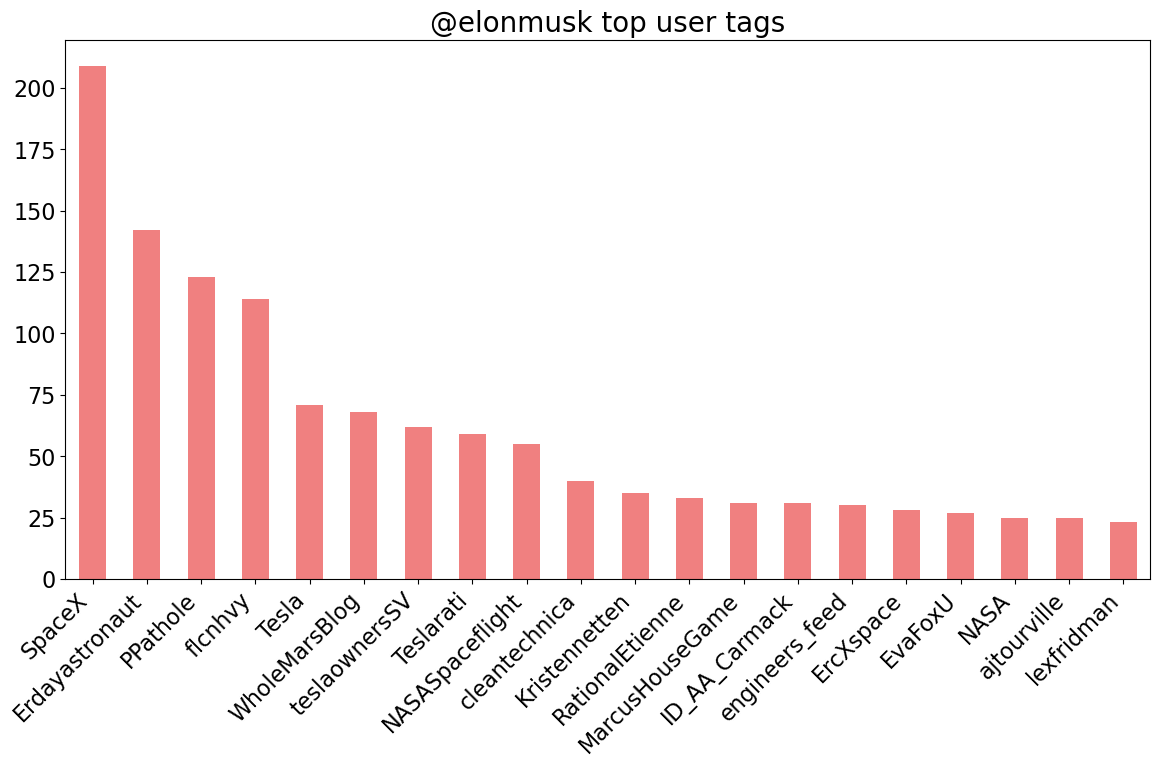

In [22]:
import itertools

c = list(
itertools.chain(
    *tweets.Tweets.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ") 
                            if '@' in handle.replace(":", "")]).tolist())
)

pd.Series(c).value_counts().head(20).plot.bar(
    figsize=(14, 7), fontsize=16, color='lightcoral'
)
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=16)
pass

## Text Pre-processing Techniques
### for Sentiment Analysis

#### Removing @names

In [38]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [39]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweets['Tidy_Tweets'] = np.vectorize(remove_pattern)(tweets['Tweets'], "@[\w]*")
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-lev...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execu...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox! https://t.co/9WFKMYu2oj
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge,\nAll thought he would..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent r...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


#### Seems good, now we don't have '@name' values


### Removing Links(http|https)

In [40]:
cleaned_tweets = []

for index, row in tweets.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Tidy_Tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets['Tidy_Tweets'] = cleaned_tweets
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


### Removing tweets with empty text

In [41]:
tweets = tweets[tweets['Tidy_Tweets']!='']
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


### Dropping duplicate rows

In [42]:
tweets.drop_duplicates(subset=['Tidy_Tweets'], keep=False)
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


###  Resetting index

In [43]:
tweets = tweets.reset_index(drop=True)
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


### Removing Punctuations, Numbers and Special characters

In [44]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [45]:
tweets['Tidy_Tweets'] = tweets['Tidy_Tweets'].apply(lambda x: clean_text(x))
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely


### Removing the Stop words

In [48]:
from nltk.corpus import stopwords
my_stop_words=stopwords.words('english')
sw_list = ['i’m','\x92','rt','ye','yeah','haha','Yes','U0001F923','I','U0001F3B6','U0001F5A4']
my_stop_words.extend(sw_list)
stopwords_set = set(my_stop_words)
cleaned_tweets = []

for index, row in tweets.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.Tidy_Tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets['absolute_tidy_tweets'] = cleaned_tweets
tweets.head(10)

,Tweets,Tidy_Tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,im an alien,im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulations tesla china amazing execution ...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox,happy new year ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...,frodo underdoge thought would fail
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks,thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...,indeed tweets definitely represent realworld t...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely,entertaining outcome likely


### Toeknizing the Tweets.

In [49]:
tokenized_tweet = tweets['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head(10)

0                                         [im, alien]
1     [ray, tracing, cyberpunk, hdr, nextlevel, tried]
2                                   [great, interview]
3                               [doge, underestimated]
4    [congratulations, tesla, china, amazing, execu...
5                               [happy, new, year, ox]
6             [frodo, underdoge, thought, would, fail]
7                                             [thanks]
8    [indeed, tweets, definitely, represent, realwo...
9                      [entertaining, outcome, likely]
Name: absolute_tidy_tweets, dtype: object

### Converting words to Lemma

In [50]:
word_lemmatizer = WordNetLemmatizer()
nltk.download('omw-1.4')

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head(10)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...


0                                         [im, alien]
1     [ray, tracing, cyberpunk, hdr, nextlevel, tried]
2                                   [great, interview]
3                               [doge, underestimated]
4    [congratulation, tesla, china, amazing, execut...
5                               [happy, new, year, ox]
6             [frodo, underdoge, thought, would, fail]
7                                             [thanks]
8    [indeed, tweet, definitely, represent, realwor...
9                      [entertaining, outcome, likely]
Name: absolute_tidy_tweets, dtype: object

### Joining all tokens into sentences

In [51]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets['absolute_tidy_tweets'] = tokenized_tweet
tweets.head(10)

,Tweets,Tidy_Tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,im an alien,im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulation tesla china amazing execution l...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox,happy new year ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...,frodo underdoge thought would fail
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks,thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...,indeed tweet definitely represent realworld ti...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely,entertaining outcome likely


## Fetch sentiments

+ Using NLTK's SentimentIntensityAnalyzer (We'll refer as SIA)

In [52]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

#### Using NLTK's SentimentIntensityAnalyzer (We'll refer as SIA)

In [53]:
sentiments_using_SIA = tweets.absolute_tidy_tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,absolute_tidy_tweets
pos,1737
neg,201


In [54]:
tweets.Tidy_Tweets[4]


'congratulations tesla china for amazing execution last year now on to the next for even more'

In [55]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(tweets.absolute_tidy_tweets[4])

{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.8271}

In [56]:
df=pd.DataFrame()
df['Tweets'] = tweets.absolute_tidy_tweets
df['scores'] = tweets['Tidy_Tweets'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Tweets,scores
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp..."
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp..."
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp..."


In [57]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Tweets,scores,compound
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271


In [58]:
df['sentiment'] = df['compound'].apply(lambda c: 'Positive' if c >=0.05 else ('Negative' if c<=-0.05  else 'Neutral'))
df

,Tweets,scores,compound,sentiment
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249,Positive
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732,Negative
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271,Positive
...,...,...,...,...
1933,true sound surreal negative propaganda still a...,"{'neg': 0.249, 'neu': 0.561, 'pos': 0.19, 'com...",-0.4215,Negative
1934,make sure read ur term amp condition clicking ...,"{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...",0.5994,Positive
1935,samwise gamgee,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1936,altho dumb dumber,"{'neg': 0.659, 'neu': 0.341, 'pos': 0.0, 'comp...",-0.7003,Negative


In [63]:
temp = df.groupby('sentiment').count()['Tweets'].reset_index().sort_values(by='Tweets',ascending=False)
temp

,sentiment,Tweets
2,Positive,873
1,Neutral,836
0,Negative,229


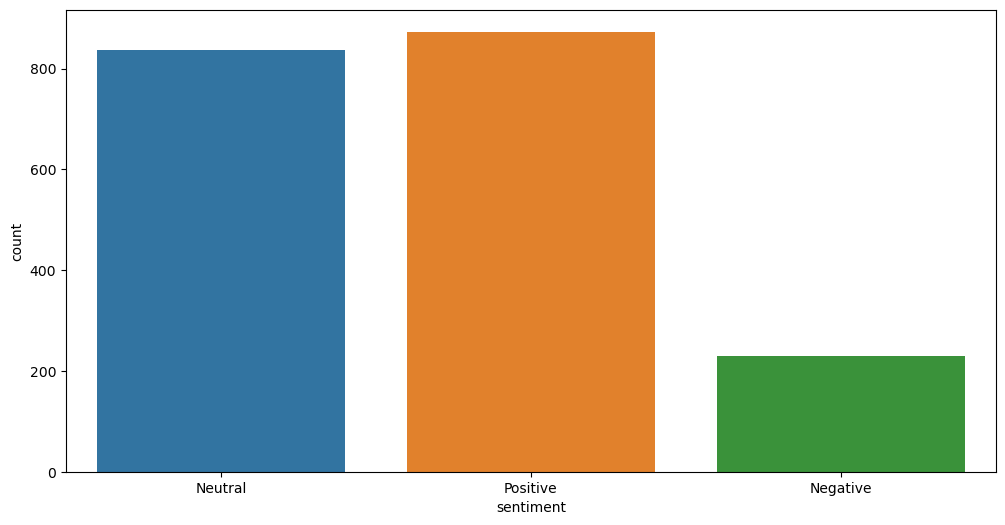

In [65]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)
plt.show()

C:\Users\sampa\AppData\Local\Temp\ipykernel_22200\1399251474.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['compound'])


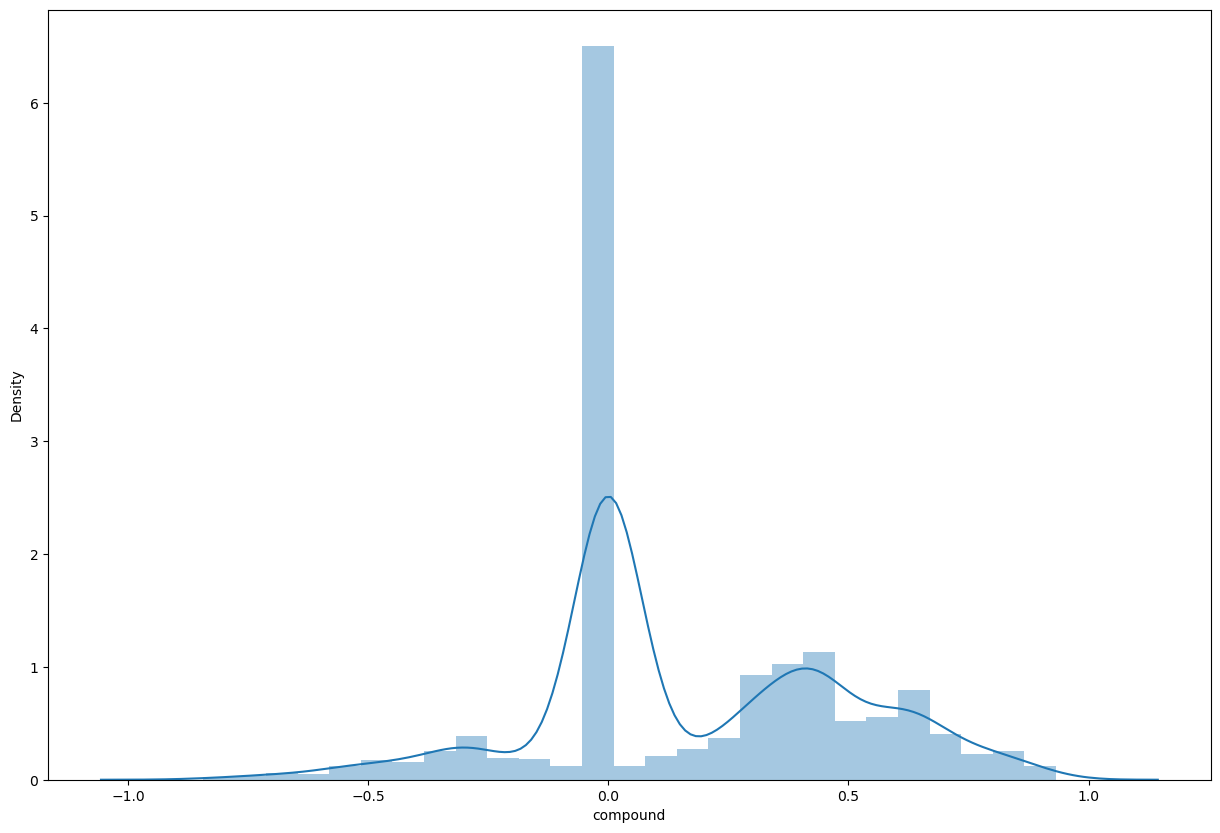

In [66]:
# Plotting the sentiment value for whole review
import seaborn as sns
plt.figure(figsize=(15,10))
sns.distplot(df['compound'])
plt.show()

<Axes: ylabel='compound'>

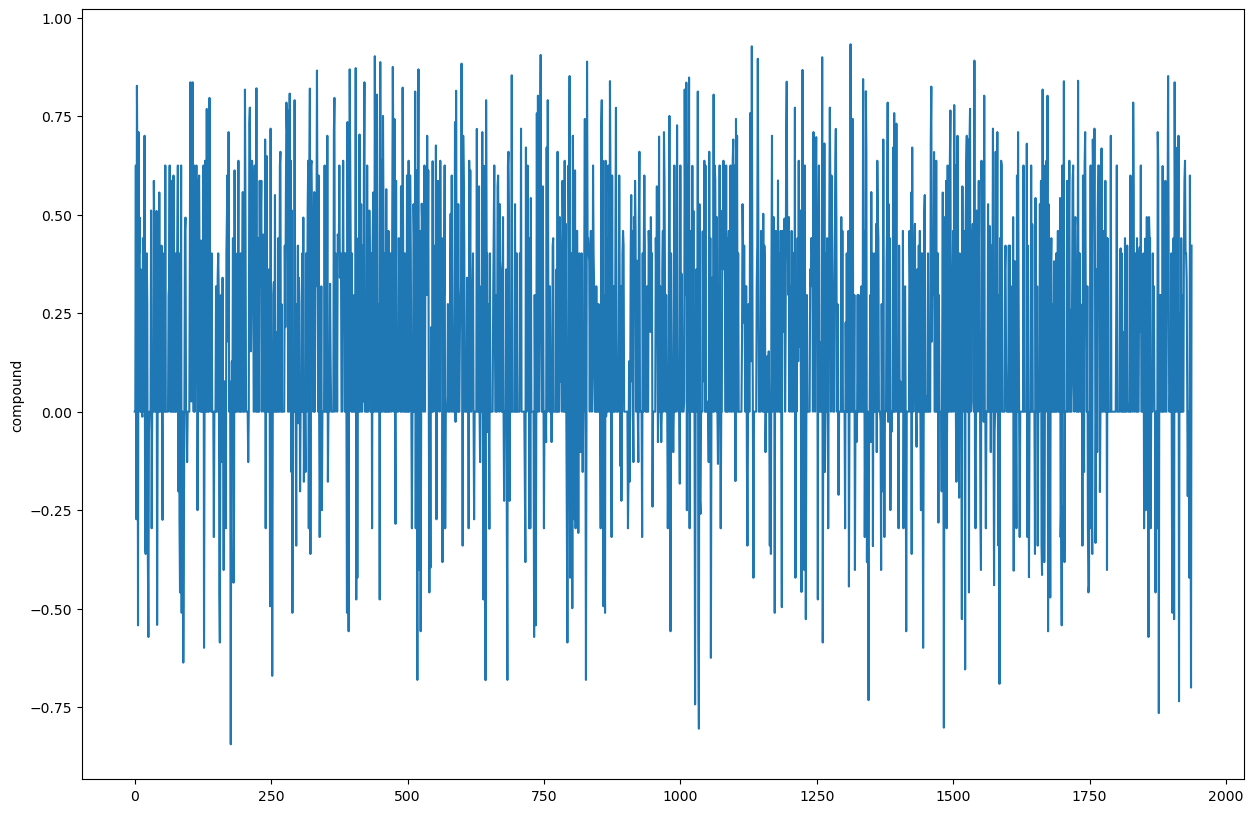

In [67]:
# Plotting the line plot for sentiment value of whole review
plt.figure(figsize=(15,10))
sns.lineplot(y='compound',x=df.index,data=df)

### From our analysis we can say that Tweets are mostly neutral to positive using nltk library